# CellPhoneDB

GitHub https://github.com/Teichlab/cellphonedb  
Publication https://www.nature.com/articles/s41596-020-0292-x

Gene names must be human ENSEMBL and the authors suggest to use non log normalized counts. 

In [10]:
library_load <- suppressMessages(
    list(
        
        # Seurat 
        library(Seurat), 
        
        # Data 
        library(dplyr),
        
        # Plotting
        library(gridExtra)
        
    )
)

In [2]:
# Set working directory to project root
setwd("/research/peer/fdeckert/FD20200109SPLENO")

In [3]:
# Source files
source("plotting_global.R")
source("bin/SingleRQC.R")

In [4]:
options(warn=-1)

# Parameter settings

In [5]:
# Seurat object
so_file <- "data/object/qc/so_qc_treatment_reg.rds"

# Plotting Theme
ggplot2::theme_set(theme_global_set()) # From project global source()

# Import Seurat object

In [6]:
so <- readRDS(so_file)

# Cluster annotation 

In [7]:
ref <- readRDS("data/haemosphere/se_haemosphere.rds")

In [107]:
so <- lapply(so, SingleRSeurat, ref=ref, cluster="SCT_snn_res.0.8")

Running SingleR in cluster mode

Running SingleR in cluster mode



# Generate non log normalized counts 

In [108]:
so_nacl <- CreateSeuratObject(GetAssayData(so[["NaCl"]], assay="RNA", slot="counts"))
so_nacl <- AddMetaData(so[["NaCl"]], so[["NaCl"]]@meta.data)
so_cpg <- CreateSeuratObject(GetAssayData(so[["CpG"]], assay="RNA", slot="counts"))
so_cpg <- AddMetaData(so[["CpG"]], so[["CpG"]]@meta.data)

In [109]:
so_nacl <- NormalizeData(so_nacl, normalization.method = "RC", scale.factor = 10^4)
so_cpg <- NormalizeData(so_cpg, normalization.method = "RC", scale.factor = 10^4)

# Export matrix for CellPhoneDB

## Function to tranlate mouse symbols to human ensemble

In [110]:
mouse2human <- function(mouse_symbol){
    
    # Require packages 
    require("biomaRt")
    
    # Set ssl for biomart  
    httr::set_config(httr::config(ssl_verifypeer=FALSE))
    
    # Get biomart
    human=useMart("ensembl", dataset="hsapiens_gene_ensembl")
    mouse=useMart("ensembl", dataset="mmusculus_gene_ensembl")
    
    # Translate symbols
    result=getLDS(attributes=c("mgi_symbol"), filters="mgi_symbol", values=mouse_symbol , mart=mouse, attributesL=c("hgnc_symbol"), martL=human, uniqueRows=TRUE)
    colnames(result) <- c("mgi_symbol", "hgnc_symbol")
    
    return(result)
    
}

In [152]:
convert <- mouse2human(unique(c(rownames(so_nacl), rownames(so_cpg))))

In [161]:
convert <- convert[convert$mgi_symbol %in% names(table(convert$mgi_symbol)[table(convert$mgi_symbol) == 1]), ]
convert <- convert[convert$hgnc_symbol %in% names(table(convert$hgnc_symbol)[table(convert$hgnc_symbol) == 1]), ]

## Process NaCl samples

In [167]:
so_nacl_meta <- data.frame(Cell=colnames(so_nacl), cell_type=paste(so_nacl$fine_labels_cluster, so_nacl$`SCT_snn_res.0.8`))
write.table(so_nacl_meta, file="data/cellphonedb/nacl/meta.txt", row.names=FALSE, quote=FALSE, sep="\t")

so_nacl_counts <- GetAssayData(so_nacl, assay="RNA", slot="data") %>% as.data.frame()
so_nacl_counts <- cbind(data.frame(mgi_symbol=rownames(so_nacl_counts)), so_nacl_counts)
so_nacl_counts <- dplyr::left_join(so_nacl_counts, convert, by = "mgi_symbol")
so_nacl_counts <- na.omit(so_nacl_counts)
so_nacl_counts <- dplyr::select(so_nacl_counts, -mgi_symbol)
so_nacl_counts <- dplyr::rename(so_nacl_counts, Gene=hgnc_symbol)
so_nacl_counts <- dplyr::select(so_nacl_counts, Gene, everything())
write.table(so_nacl_counts, file="data/cellphonedb/nacl/counts.txt", row.names=FALSE, quote=FALSE, sep="\t")

## Process CpG samples 

In [168]:
so_cpg_meta <- data.frame(Cell=colnames(so_cpg), cell_type=paste(so_cpg$fine_labels_cluster, so_cpg$`SCT_snn_res.0.8`))
write.table(so_cpg_meta, file="data/cellphonedb/cpg/meta.txt", row.names=FALSE, quote=FALSE, sep="\t")

so_cpg_counts <- GetAssayData(so_cpg, assay="RNA", slot="data") %>% as.data.frame()
so_cpg_counts <- cbind(data.frame(mgi_symbol=rownames(so_cpg_counts)), so_cpg_counts)
so_cpg_counts <- dplyr::left_join(so_cpg_counts, convert, by = "mgi_symbol")
so_cpg_counts <- na.omit(so_cpg_counts)
so_cpg_counts <- dplyr::select(so_cpg_counts, -mgi_symbol)
so_cpg_counts <- dplyr::rename(so_cpg_counts, Gene=hgnc_symbol)
so_cpg_counts <- dplyr::select(so_cpg_counts, Gene, everything())
write.table(so_cpg_counts, file="data/cellphonedb/cpg/counts.txt", row.names=FALSE, quote=FALSE, sep="\t")

# Plot results

In [8]:
source("script/cellphonedb/plot_heatmaps.R")
source("script/cellphonedb/plot_dot.R")

## NaCl samples interaction 

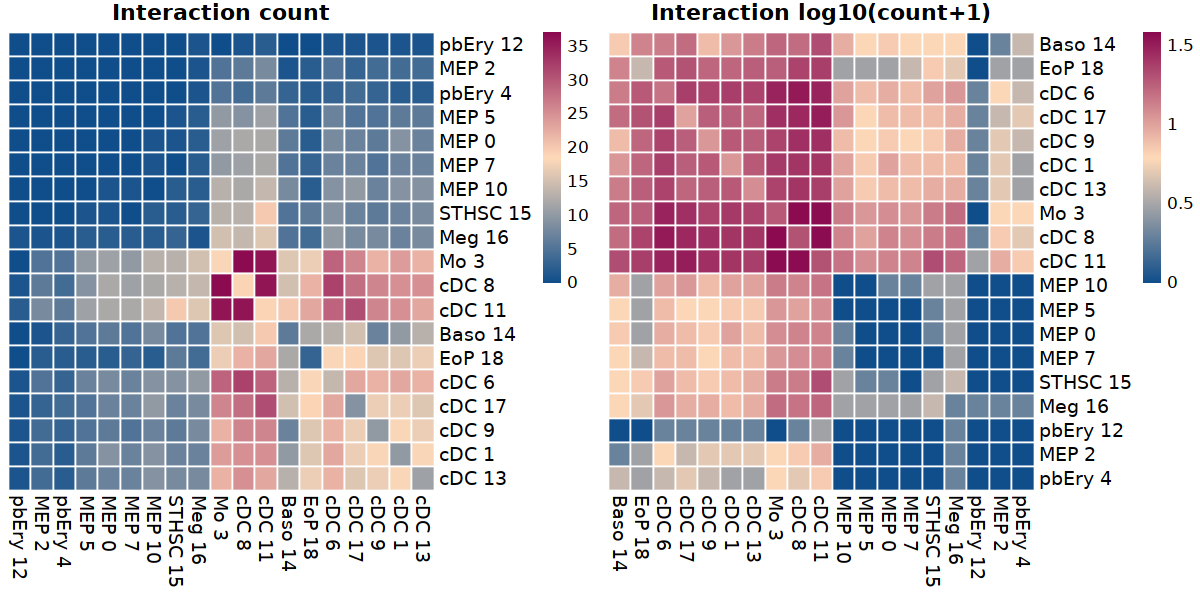

In [11]:
options(repr.plot.width=10, repr.plot.height=5)
plot_nacl <- heatmaps_plot(meta_file="data/cellphonedb/nacl/meta.txt", pvalues_file="data/cellphonedb/nacl/out/pvalues.txt")
plot_nacl_grid <- arrangeGrob(grobs=list(plot_nacl[[1]][[4]], plot_nacl[[2]][[4]]), ncol=2)
ggsave(plot_nacl_grid, filename="result/cellphonedb/hm_nacl.jpg", width=10, height=5)
grid::grid.draw(plot_nacl_grid)

# CpG samples interaction

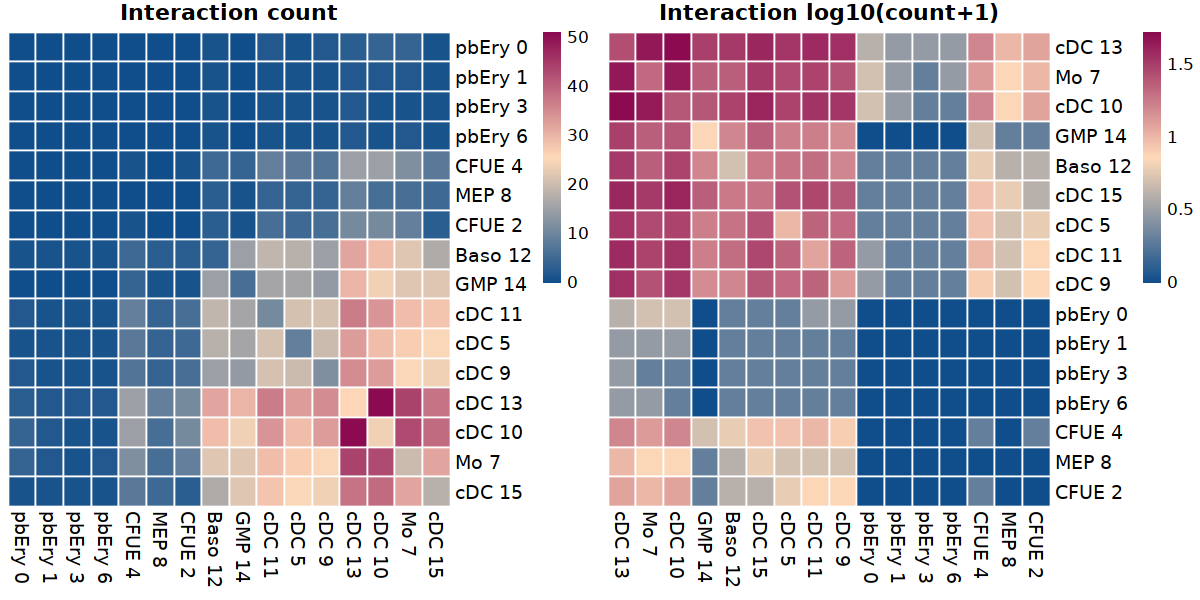

In [12]:
options(repr.plot.width=10, repr.plot.height=5)
plot_cpg <- heatmaps_plot(meta_file="data/cellphonedb/cpg/meta.txt", pvalues_file="data/cellphonedb/cpg/out/pvalues.txt")
plot_cpg_grid <- arrangeGrob(grobs=list(plot_cpg[[1]][[4]], plot_cpg[[2]][[4]]), ncol=2)
ggsave(plot_cpg_grid, filename="result/cellphonedb/hm_cpg.jpg", width=10, height=5)
grid::grid.draw(plot_cpg_grid)